In [24]:
import numpy as np
import pandas as pd
from matplotlib import rc
rc("animation", html="jshtml")

import importlib
import models
importlib.reload(models)
import tools
importlib.reload(tools)

from tools import (
    animate_week_play,
    get_din_dout,
    test_frame_alignment,
    visualize_predictions,
)
from models import (
    KinematicModel,
    train_eval_model,
    KinematicBoundaryModel,
    BayesianKinematicModel,
    fit_model_up_to_week,
    train_eval_until_week,
)

In [25]:
def get_game_play_index(input_path):
    df_ids = pd.read_csv(input_path, usecols=["game_id", "play_id"])
    df_ids = df_ids.drop_duplicates().sort_values(["game_id", "play_id"])
    return df_ids

In [26]:
week = 6 # 18 weeks
index_df = get_game_play_index(f"train/input_2023_w{week:02d}.csv")
print(index_df.index)
print(f"{index_df.shape[0]} indices for week {week}")
idx = 7
gi = index_df.iloc[idx].game_id
pi = index_df.iloc[idx].play_id

Index([     0,    176,    880,   1210,   1705,   1969,   2320,   2650,   3092,
         3456,
       ...
       266999, 267298, 267610, 267840, 268100, 268464, 268926, 269498, 269806,
       270196],
      dtype='int64', length=793)
793 indices for week 6


In [27]:
animate_week_play(week=week, game_id=gi, play_id=pi, pre_only=False, pause_time=None)

In this clip (``week``=3, ``idx``=7), the QB moves ever-so-slightly before throwing towards the direction of the throw. This could be a good predictor of player movement. Also, it could give a better estimate of ball throw velocity to get an idea of how far the ball will be thrown and therefore which reciever will be targeted.

In this clip, Let's label each defender and analyze their movements.

Defender 1 (tracking target receiver)
- ...

Defender 2 (tracking offense player at last pre-frame)
- starts by moving with the offensive player he is targeting.
- As soon as ball goes over their heads, he breaks towards endzone to try to tackle the target reviever if the target reciever catches the ball and breaks away.
- It looks like his defensive movement has two phases. He starts with shadowing the closest offensive player to him, and then when the ball goes past him, he switches to run towards the endzone/ball trajectory.

Defender 3 (protecting against breakaway)
- ...

Looking at ``week``=6, ``idx``=7, there is a sort-of outlier case. The players leave the target reciever open. There's still a "defender 3" of sorts from the previous analysis that hangs back to protect against breakaways, but it's interesting how none of the defenders are able to cover the target reciever after the ball is thrown.

Create a model that first just uses teh QB position to predict the probability that each reciever is targeted.

The idea is that the QB movement towards a receiver increases or decreases the probability that the reciever is targeted.

Create a visualization that shows the probability each player is the target reciever in a plot that changes with time and the animate_week_play animation on the left.

As for defenders, some of them mirror the movement of other offense players. The best predictor of a defender's movement is some combination of the targeted reciever's movement, ball trajectory, qb movement before throw, other defensive players, and the defender's respective target offensive player.

Oh! I see, so if you look at the footage, two of the defenders are protecting breakaway routes. But the offender who is targeted by the quarterback is actually not one of the breakaway routes. Instead, he is in line with another reciever but closer to the quarterback. So when the ball is thrown, it looks like the defenders should guard the breakaway reciever in case they catch the ball, leaving the closer reciever open to catch the ball.

And the bottom left highlighted defender starts changing his momentum to go towards the reciever would be if the reciever catches the ball and gets past the existing defenders.

One of the defenders must be targeting an opponent though. Maybe also the QB. This should be looked into because after the ball is thrown, you'd expect the player's trajectory to change towards the ball if he is not near any offensive players, but it does not. Are there any untracked offensive players from the pre-frames data?

## Defensive player model:
- Construct probability that defensive player j is tracking offensive player i. (including QB)
- Construct probability that definsive plaler j will track the ball_target or target_player.
- Construct probability that defensive player j will move to intercept the ball based on ball trajectory and speed.

Given probabilities, predict defensive player movement. As each frame comes in, update the probabilities of which "regime" or "state" the defensive player is in, and from that state, predict the player's movement by using the state-associated model for defensive player movement given state.

## Offensive player model:
- ...

Maybe some stochastic bayes model, or time-series dependent bayes model? Might need to do some research.

Also need a good loss function for each model.

Kaggle evaluation metric is RMSE of predicted vs actual player locations at each time.

# Model

# To improve the base kinematic model, you should predict more than 1 frame ahead. For example, the player won't continue running straight into the bounds at full speed, if you see they're going to reach bounds in 4 time frames, then expect them to slow down or change direction to go away from the thrower or avoid a defender.

In [4]:
# Deterministic baseline
model = KinematicBoundaryModel(fps=10.0, use_accel=True)
model = fit_model_up_to_week(
    model,
    max_train_week=3,
    source="input",  # input_2023_* has s,a,dir
)

ani_det = visualize_predictions(
    model,
    week=week,
    game_id=gi,
    play_id=pi,
    horizon=3,
    interval=120,
    pause_time=None,
)
ani_det


[fit_model_up_to_week] Training on weeks: [1, 2, 3]


Building step df (input):   0%|          | 0/3 [00:00<?, ?week/s]

[fit_model_up_to_week] Fitting model 'kinematic_with_boundaries' on 840,437 rows...
[fit_model_up_to_week] Done fitting 'kinematic_with_boundaries'.


In [5]:
bayes_model = BayesianKinematicModel(fps=10.0, use_accel=True)
bayes_model = fit_model_up_to_week(
    bayes_model,
    max_train_week=3,
    source="input",   # IMPORTANT: needs s,a,dir
    # you can pass PyMC sampling args here too:
    draws=500,
    tune=500,
    target_accept=0.9,
    chains=2,
)


[fit_model_up_to_week] Training on weeks: [1, 2, 3]


Building step df (input):   0%|          | 0/3 [00:00<?, ?week/s]

Initializing NUTS using jitter+adapt_diag...


[fit_model_up_to_week] Fitting model 'bayes_kinematic' on 840,437 rows...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_x, sigma_y]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 50 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


[fit_model_up_to_week] Done fitting 'bayes_kinematic'.


In [6]:

ani_bayes = visualize_predictions(
    bayes_model,
    week=week,
    game_id=gi,
    play_id=pi,
    horizon=3, # Number of cones
    interval=120,
    pause_time=None,
    bayes_samples=200,
    cone_pct=0.95, # Cone percentage
)
ani_bayes

# CUT

In [6]:
import pandas as pd
import numpy as np

THRESHOLD = 2

week = 1 # 18 weeks
input_path = f"train/input_2023_w{week:02d}.csv"
df = pd.read_csv(input_path)
df = df.sort_values(["game_id", "play_id", "frame_id"]).copy()

# Isolate Targeted Receiver rows
target = df[df["player_role"] == "Targeted Receiver"].copy()

# Compute distance to ball landing location at each frame
target["dist_to_ball_land"] = np.sqrt(
    (target["x"] - target["ball_land_x"])**2 +
    (target["y"] - target["ball_land_y"])**2
)

# for each (game_id, play_id), take the final frame only
final_target = (
    target
    .sort_values("frame_id")
    .groupby(["game_id", "play_id"])
    .tail(1)
)

final_target["play_success"] = (
    final_target["dist_to_ball_land"] <= THRESHOLD
).astype(int)

play_labels = final_target[[
    "game_id", "play_id", "play_success"
]]

df = df.merge(
    play_labels,
    on=["game_id", "play_id"],
    how="left"
)

print(df[["game_id", "play_id", "frame_id", "play_success"]].head(20))

# Check probability of success
df_final_frame = df.copy()
df_final_frame = df_final_frame[['game_id', 'play_id', 'play_success']].drop_duplicates(subset=['game_id', 'play_id'])
success_rate = float(df_final_frame['play_success'].mean())
success_rate


       game_id  play_id  frame_id  play_success
0   2023090700      101         1             0
1   2023090700      101         1             0
2   2023090700      101         1             0
3   2023090700      101         1             0
4   2023090700      101         1             0
5   2023090700      101         1             0
6   2023090700      101         1             0
7   2023090700      101         1             0
8   2023090700      101         1             0
9   2023090700      101         2             0
10  2023090700      101         2             0
11  2023090700      101         2             0
12  2023090700      101         2             0
13  2023090700      101         2             0
14  2023090700      101         2             0
15  2023090700      101         2             0
16  2023090700      101         2             0
17  2023090700      101         2             0
18  2023090700      101         3             0
19  2023090700      101         3       

0.12087912087912088

In [7]:
def build_play_level_features(df_with_labels: pd.DataFrame) -> pd.DataFrame:
    """
    One row per (game_id, play_id), using the *final input frame*
    as a proxy for the throw moment, plus the play_success label.
    """
    df = df_with_labels.sort_values(["game_id", "play_id", "frame_id"]).copy()

    plays = []
    for (gid, pid), g in df.groupby(["game_id", "play_id"], sort=False):
        last = g.iloc[-1]  # last input frame (pre-throw cutoff)

        # pull label (same across frames for this play)
        y = last["play_success"]

        # absolute yardline
        abs_yardline = last["absolute_yardline_number"]

        # target receiver row in this frame
        tg = g[g["player_role"] == "Targeted Receiver"].iloc[-1]

        # distance from target receiver to ball landing
        dist_target_to_land = float(
            np.sqrt(
                (tg["x"] - tg["ball_land_x"])**2 +
                (tg["y"] - tg["ball_land_y"])**2
            )
        )

        # defenders near landing point (within 5 yards)
        defenders = g[g["player_side"] == "Defense"].iloc[-1:]
        dx = defenders["x"] - last["ball_land_x"]
        dy = defenders["y"] - last["ball_land_y"]
        d_def = np.sqrt(dx**2 + dy**2)
        num_def_close = int((d_def <= 5.0).sum())

        plays.append({
            "game_id": gid,
            "play_id": pid,
            "play_success": int(y),
            "abs_yardline_at_throw": float(abs_yardline),
            "dist_target_to_land": dist_target_to_land,
            "num_defenders_close": num_def_close,
        })

    return pd.DataFrame(plays)

play_df = build_play_level_features(df)
play_df.head()


game_id  play_id  play_success  abs_yardline_at_throw  \
0  2023090700      101             0                   42.0   
1  2023090700      194             0                   89.0   
2  2023090700      219             1                   79.0   
3  2023090700      361             0                   22.0   
4  2023090700      436             0                   31.0   

   dist_target_to_land  num_defenders_close  
0            17.986063                    0  
1             4.068413                    0  
2             1.276636                    0  
3             8.134531                    0  
4             3.220062                    0

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

feature_cols = ["abs_yardline_at_throw", "dist_target_to_land", "num_defenders_close"]

X = play_df[feature_cols].to_numpy()
y = play_df["play_success"].to_numpy()

logit_clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
logit_clf.fit(X, y)

# in-sample check
probs = logit_clf.predict_proba(X)[:, 1]
print("Mean predicted success prob:", probs.mean())


Mean predicted success prob: 0.12087587242120715


In [9]:
import pymc as pm
import numpy as np

X = play_df[feature_cols].to_numpy()
y = play_df["play_success"].to_numpy()
n_features = X.shape[1]

with pm.Model() as play_success_model:
    # heavy-tailed prior on weights
    beta0 = pm.StudentT("beta0", nu=3, mu=0.0, sigma=5.0)              # intercept
    beta  = pm.StudentT("beta",  nu=3, mu=0.0, sigma=2.0, shape=n_features)

    logits = beta0 + pm.math.dot(X, beta)
    p = pm.Deterministic("p", pm.math.sigmoid(logits))

    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    trace = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.9,
        chains=2,
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
There were 749 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

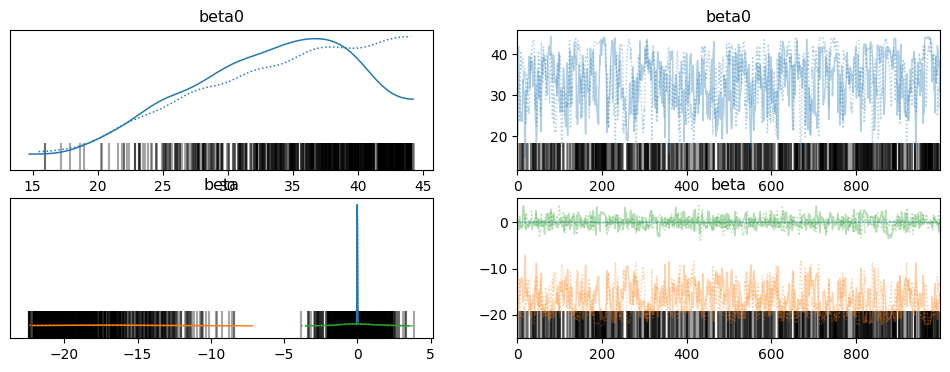

In [17]:
pm.summary(trace, var_names=["beta0", "beta"])
pm.plot_trace(trace, var_names=["beta0", "beta"])


In [18]:
import numpy as np

def bayes_play_success_probs(X_new: np.ndarray, trace) -> np.ndarray:
    """
    X_new: shape (n_plays, n_features)
    returns: posterior mean prob of success per play (shape (n_plays,))
    """
    beta0_samps = trace.posterior["beta0"].values.reshape(-1)
    beta_samps  = trace.posterior["beta"].values.reshape(-1, n_features)

    n_samples = beta0_samps.shape[0]
    X_new = np.atleast_2d(X_new)
    n_plays = X_new.shape[0]

    probs = np.zeros((n_samples, n_plays))
    for i in range(n_samples):
        logits = beta0_samps[i] + X_new @ beta_samps[i]
        probs[i, :] = 1 / (1 + np.exp(-logits))

    return probs.mean(axis=0), probs  # mean and all samples


In [19]:
def build_frame_features_for_play(d_play: pd.DataFrame) -> pd.DataFrame:
    """
    d_play: df filtered to a single (game_id, play_id) from input csv.
    Returns one row per frame with features and frame index.
    """
    d_play = d_play.sort_values("frame_id").copy()

    # distance target -> land PER frame
    target = d_play[d_play["player_role"] == "Targeted Receiver"]
    # align by frame_id
    d_t = (
        target[["frame_id", "x", "y", "ball_land_x", "ball_land_y"]]
        .rename(columns={"x": "tgt_x", "y": "tgt_y"})
    )
    d_frames = d_play[["frame_id", "absolute_yardline_number"]].drop_duplicates("frame_id")
    d_frames = d_frames.merge(d_t, on="frame_id", how="left")

    d_frames["dist_target_to_land"] = np.sqrt(
        (d_frames["tgt_x"] - d_frames["ball_land_x"])**2 +
        (d_frames["tgt_y"] - d_frames["ball_land_y"])**2
    )

    # defenders near ball landing point per frame
    def_count = []
    for f, g in d_play.groupby("frame_id", sort=True):
        defenders = g[g["player_side"] == "Defense"]
        dx = defenders["x"] - g["ball_land_x"].iloc[0]
        dy = defenders["y"] - g["ball_land_y"].iloc[0]
        d_def = np.sqrt(dx**2 + dy**2)
        def_count.append({"frame_id": f, "num_defenders_close": int((d_def <= 5.0).sum())})

    d_defc = pd.DataFrame(def_count)
    d_frames = d_frames.merge(d_defc, on="frame_id", how="left")

    d_frames["abs_yardline_at_throw"] = d_frames["absolute_yardline_number"]
    return d_frames[["frame_id", "abs_yardline_at_throw", "dist_target_to_land", "num_defenders_close"]]


In [20]:
index_df = get_game_play_index(f"train/input_2023_w{week:02d}.csv")
print(index_df.index)
print(f"{index_df.shape[0]} indices for week {week}")
idx = 7



Index([     0,    234,    650,    871,   1432,   1652,   1951,   2211,   2588,
         2900,
       ...
       282515, 282840, 283321, 283659, 283839, 284055, 284458, 284806, 284986,
       285285],
      dtype='int64', length=819)
819 indices for week 1


In [21]:

gid = index_df.iloc[idx].game_id
pid = index_df.iloc[idx].play_id
d_play = df[(df.game_id == gid) & (df.play_id == pid)]

frame_feats = build_frame_features_for_play(d_play)
X_frames = frame_feats[feature_cols].to_numpy()

p_mean_frames, p_samples_frames = bayes_play_success_probs(X_frames, trace)
frame_feats["p_success"] = p_mean_frames

In [22]:
from tools import visualize_predictions, get_din_dout

game_id = gid
play_id = pid

d_in, _ = get_din_dout(week, game_id, play_id)
d_play = d_in.sort_values(["frame_id"])

frame_feats = build_frame_features_for_play(d_play)
X_frames = frame_feats[feature_cols].to_numpy()
p_mean_frames, p_samples_frames = bayes_play_success_probs(X_frames, trace)

# map frame_id -> prob in the same order as visualize_predictions' seq
p_by_frame = dict(zip(frame_feats["frame_id"].values, p_mean_frames))


In [23]:
ani = visualize_predictions(
    model,
    week=week,
    game_id=gid,
    play_id=pid,
    horizon=3,
    p_by_frame=p_by_frame
)
ani

NameError: name 'model' is not defined